# This model over samples using bootstrapping for the failure metrics to account for the imbalance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay,
                             f1_score,)

#### Loading initial data

In [2]:
initial_data = pd.read_csv('../data/ai4i2020.csv')

#### Oversampling performed

In [3]:
# Get all non failed rows
non_failures = initial_data[initial_data['Machine failure'] == 0]
amnt_non_failures = len(non_failures)
non_failures.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# Get all failed rows
failures = initial_data[initial_data['Machine failure'] == 1]
over_sampled_failures = failures.sample(n=amnt_non_failures, replace=True)
print(len(over_sampled_failures))
over_sampled_failures.value_counts()

9661


UDI   Product ID  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
4644  L51823      L     303.2                311.4                    1324                    54.2         228              1                0    1    0    1    0      44
4180  L51359      L     302.4                310.9                    1349                    46.1         148              1                0    1    0    0    0      43
4410  M19269      M     302.4                310.1                    1358                    54.6         61               1                0    1    0    0    0      43
4537  L51716      L     302.4                310.2                    1351                    45.1         168              1                0    1    0    0    0      43
4165  L51344      L     302.2                310.6                    1346                    47.5         109              1                0    1    

In [5]:
# Create final dataframe for model to use
oversampled_data = pd.concat([over_sampled_failures, non_failures])

In [6]:
# View the distribution of the data
oversampled_data["Machine failure"].value_counts()

Machine failure
1    9661
0    9661
Name: count, dtype: int64

#### Convering Type column into binary values for model preperation

In [7]:
dummy = pd.get_dummies(oversampled_data['Type'], dtype=int, drop_first=True)

In [8]:
cleaned_data = pd.concat([oversampled_data, dummy], axis=1)

In [9]:
cleaned_data.drop(columns=["Type", "Product ID", "UDI", "TWF", "HDF", "PWF", "OSF", "RNF"], inplace=True)

In [10]:
cleaned_data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,L,M
5536,302.3,311.8,1363,54.0,119,1,0,1
1123,296.6,307.7,1386,62.3,100,1,0,0
168,298.4,308.3,1433,62.3,20,1,1,0
1763,298.2,307.6,1511,31.0,209,1,1,0
77,298.8,308.9,1455,41.3,208,1,1,0


In [11]:
X = cleaned_data.drop(columns=["Machine failure"])
X

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],L,M
5536,302.3,311.8,1363,54.0,119,0,1
1123,296.6,307.7,1386,62.3,100,0,0
168,298.4,308.3,1433,62.3,20,1,0
1763,298.2,307.6,1511,31.0,209,1,0
77,298.8,308.9,1455,41.3,208,1,0
...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,1
9996,298.9,308.4,1632,31.8,17,0,0
9997,299.0,308.6,1645,33.4,22,0,1
9998,299.0,308.7,1408,48.5,25,0,0


In [12]:
y = cleaned_data["Machine failure"]
y.value_counts()

Machine failure
1    9661
0    9661
Name: count, dtype: int64

#### Creating Logistic Regression Model

In [13]:
log_model = LogisticRegression(max_iter=1000)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

y_test.value_counts()

Machine failure
1    2426
0    2405
Name: count, dtype: int64

#### Training Model


In [14]:
for train_set, val_set in kf.split(X_train):
    X_train_split, y_train_split = X_train.iloc[train_set], y_train.iloc[train_set]
    X_val_split, y_val_split = X_train.iloc[val_set], y_train.iloc[val_set]
    log_model.fit(X_train_split, y_train_split)
    model_predictions = log_model.predict(X_val_split)

    accuracy_scores.append(accuracy_score(y_val_split, model_predictions))
    precision_scores.append(precision_score(
        y_val_split, model_predictions, zero_division=0))
    recall_scores.append(recall_score(y_val_split, model_predictions))
    f1_scores.append(f1_score(y_val_split, model_predictions))

In [15]:
scores = cross_val_score(log_model, X, y, cv=5)

#### Assessing model's performance from splits

In [16]:
print(f"Average Accuracy Score: {np.mean(accuracy_scores) * 100}")
print(f"Average Precision Score: {np.mean(precision_scores) * 100}")
print(f"Average Recall Score: {np.mean(recall_scores) * 100}")
print(f"Average F1 Score: {np.mean(f1_scores) * 100}")

Average Accuracy Score: 82.43736982672448
Average Precision Score: 82.31132504548212
Average Recall Score: 82.53355715253025
Average F1 Score: 82.41824339568515


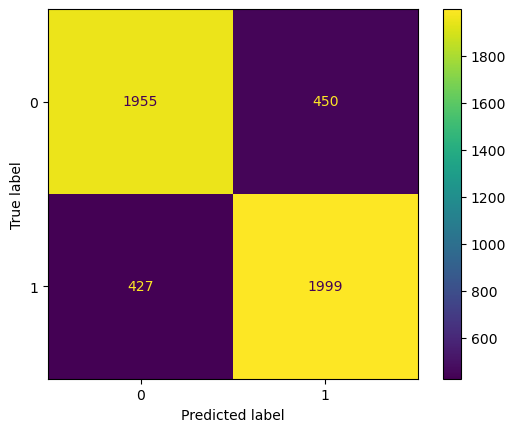

In [17]:
# Confusion Matrix
log_model.fit(X_train, y_train)
model_predictions = log_model.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, model_predictions)).plot()